Some rotation of the polarisation of the flakes were observed in the magnet.
It is suspected that this happens during the cooldown.
Therefore a new sample was prepared and cooled down.    
To determine the rotation of the crystal axis, polarised raman measurements were performed.
In case the entire flake rotates pictures of the crystals were taken.

In [2]:
from lib.preamble import *
import h5py

%matplotlib inline

data = []

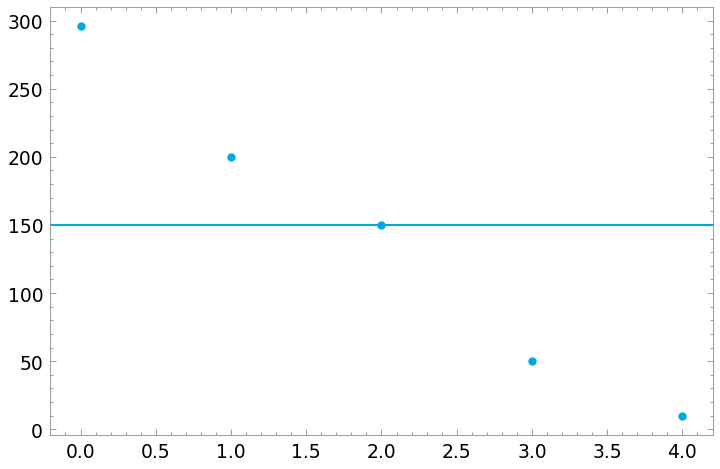

In [3]:
temperatures = np.array([296, 200, 150, 50, 10])
plt.plot(temperatures, "o")
plt.axhline(150)

In [4]:
def cos_sqr(x, *p):
	return p[0] * np.cos((x-p[1])) ** 2 + p[2]

def fit_cos_sqr(angle, intens, p0=None):
	if p0 is None:
		p0 = [intens.max() - intens.min(), np.pi/2, intens.min()]
	popt, pcov = sp.optimize.curve_fit(cos_sqr, angle, intens, 
		p0=p0,
		bounds=(
			[0, -np.inf, 0],
			[np.inf, np.inf, np.inf]
		)
	)
	popt[1] = popt[1] % np.pi
	return popt, pcov

In [5]:
def import_anisotropy(p:str):
	with h5py.File(p, "r") as f:
		f = h5py.File(p, "r")
		wavelength = f["x"][0]
		angle = f["y"][:]
		counts = f["z"][:]

		exposure = f['data_full']['spectrometer']["exposure"][0]
		number = f['data_full']['spectrometer']["number"][0]
		temperature = np.mean(f["data_full"]["lakeshore"]["temperatureA"])
  
	ar = xr.DataArray(
    	counts/number,
		coords={
			"angle": angle*2*np.pi/180,
			"wavelength": wavelength,
		},
		attrs={
			"temperature": temperature,
			"exposure": exposure,
			"number": number,
			"path": p,
			"flake": int(p.split("flake")[1].replace(".", "_").split("_")[0]),
		},
		name = ".".join(p.split("data/")[-1].split(".")[:-2])
    )
	return ar

In [6]:
paths = glob("../data/2024-01-02*/d*")
paths += glob("../data/2024-01-03*/d*")
paths.sort()

anisotropy = []
for p in [p for p in paths if p.endswith(".hd5.h5")]:
	try:
		anisotropy.append(import_anisotropy(p))
	except:
		print(p)

../data/2024-01-02/d001_mirror_through_window_10x.3s.hd5.h5
../data/2024-01-02/d004_ruby_3x.5s.hd5.h5


# 2024-01-03

## Extract data from the images

In [7]:
from basicpy import BaSiC

paths_images = [p for p in paths if p.endswith(".tiff") and "2024-01-03" in p and "d005" in p]

def import_image(p:str):
    img = plt.imread(p)
    return xr.DataArray(
		img,
		dims=["y", "x", "channel"],
		name = ".".join(p.split("data/")[-1].split(".")[:-1]),
		attrs = {
			"path": p,
			"flake": int(p.split("flake")[1].replace(".", "_").split("_")[0]),
			"temperature": float(p.split("K")[-2].split("_")[-1]),
		}
	)

images_raw = [import_image(p).sel(channel=1) for p in paths_images]

basic = BaSiC(get_darkfield=False, smoothness_flatfield=1)
basic.fit(
	np.array([img.values for img in images_raw if "flake01" not in img.name]),
)

def remove_darkfield(img, basic=basic):
	return xr.DataArray(
		basic.transform(img.values)[0],
		coords=img.coords,
		name = img.name,
		attrs = img.attrs
	)

images = [remove_darkfield(img) for img in images_raw]

ModuleNotFoundError: No module named 'basicpy'

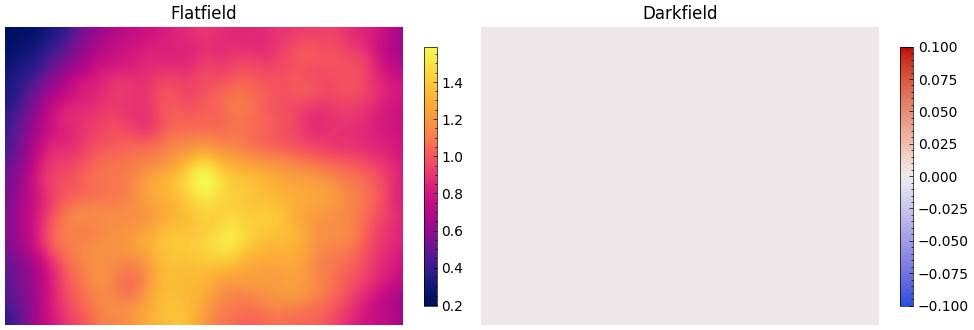

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
i = ax[0].imshow(basic.flatfield, cmap=cm["CET_L8"])
fig.colorbar(i, ax=ax[0], fraction=0.03)
ax[0].set_title("Flatfield")
i = ax[1].imshow(basic.darkfield, cmap=cm["CET_D1"])
fig.colorbar(i, ax=ax[1], fraction=0.03)
ax[1].set_title("Darkfield")
for a in ax:
	a.axis("off")
	a.set_aspect("equal")

### Look at images manually

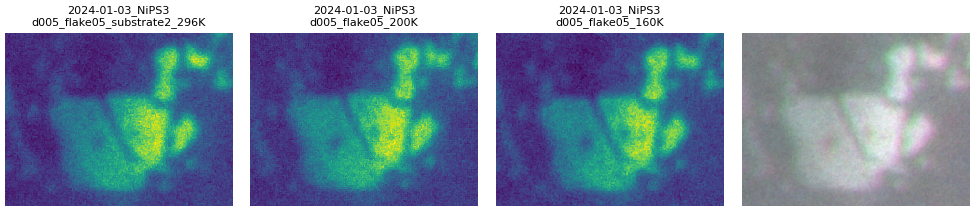

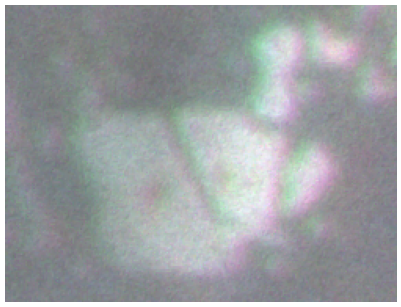

CPU times: user 4.33 s, sys: 344 ms, total: 4.67 s
Wall time: 4.31 s


In [ ]:
%%time
sel = [img for img in images if "flake05" in img.name][::-1]
sel = [i/i.mean() for i in sel]

# align the images
from pystackreg import StackReg
ref = sel[0].values
sr = StackReg(StackReg.TRANSLATION)
reg = [sr.register_transform(ref, i) for i in sel]
sel = [xr.DataArray(
    sr.transform(i.values, r),
    coords=i.coords, 
    attrs=i.attrs, 
    name=i.name
) for i, r in zip(sel, reg)]

# crop the images
sel = [i[380:570, 550:800] for i in sel]

fig, axs = plt.subplots(1, len(sel)+1, figsize=FIGSIZE_WIDE)
for img, ax in zip(sel, axs[:-1]):
	img.plot.imshow(ax=ax, add_labels=False, add_colorbar=False)
	ax.set_aspect("equal")
	ax.set_title(img.name.replace(r"/", "\n"), fontsize=FONTSIZE_TINY)

axs[-1].imshow(np.array(sel[:3]).transpose(1,2,0) / np.max(sel[:3]), origin="lower")

for a in axs: a.axis("off") 
plt.savefig("../figures/2024-01-03 flake rotation.png")
plt.show()

plt.figure()
plt.imshow(np.array([sel[0], sel[1], sel[2]]).transpose(1,2,0) / np.max(sel[:3]), origin="lower")
plt.axis("off")
plt.savefig("../figures/2024-01-03 flake rotation combined.png")
plt.show()

## Anisotropy of the crystal

In [ ]:
sel = [a for a in anisotropy if "2024-01-03" in a.path and "296K" in a.path]

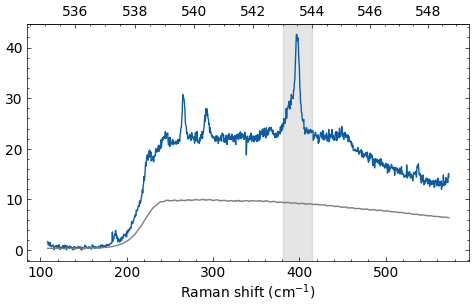

<xarray.DataArray 'wavelength' ()>
array(396.98457495)


In [ ]:
d = sel[0].mean("angle")
filter_function = import_spectrum("../data/2024-01-03_NiPS3/d003_filterFunction.asc")
filter_function = xr.DataArray(
	filter_function["intensity"],
	coords={"wavelength": filter_function["wavelength"]},
	dims=["wavelength"],
	name="filter function"
)
# d = d / filter_function.interp(wavelength=d.wavelength)

n = d-d.min()

def raman(raman, laser=532): return 1e7 * (1/laser - 1/raman)
def raman_inv(raman, laser=532): return 1/(1/laser - 1e-7 * raman)

plt.figure()
plt.plot(raman(d.wavelength), n)
plt.axvspan(raman(543),raman(544), alpha=0.2, color="gray")
plt.plot(raman(filter_function.wavelength), filter_function/filter_function.max() * 10, color="gray")
plt.xlabel("Raman shift (cm$^{-1}$)")
plt.gca().xaxis.set_ticks_position('bottom')
plt.gca().secondary_xaxis('top', functions=(raman_inv, raman))
plt.show()

print(raman(d.idxmax("wavelength")))

In [ ]:
sel[0].attrs

{'temperature': 295.9533333333333,
 'exposure': 20.0,
 'number': 3,
 'path': '../data/2024-01-03_NiPS3/d005_flake01_296K.hd5.h5',
 'flake': 1}

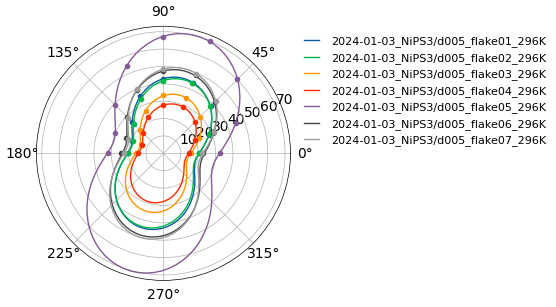

In [ ]:
# plot all anisotropy
ax = plt.subplot(111, projection='polar')
for a in sel:
    n = a.sel(wavelength=slice(543,544)).mean("wavelength")
    n = n - a.min()
    m = n.plot(linestyle="", marker="o", _labels=False)
    popt, _ = fit_cos_sqr(n.angle, n, p0=[0.1, np.pi/2, 0])
    angles = np.linspace(0, 2*np.pi, 100)
    ax.plot(angles, cos_sqr(angles, *popt), label=a.name, color=m[0].get_color())
plt.legend(bbox_to_anchor=(1.0, 1.0), fontsize=FONTSIZE_TINY)
plt.show()

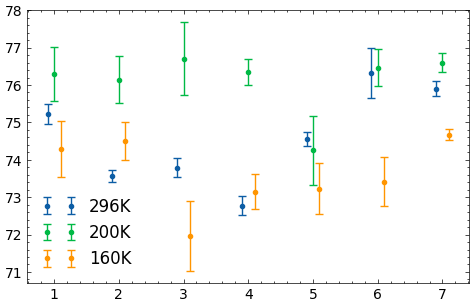

In [ ]:
def pre(a):
	n = a.sel(wavelength=slice(543,544)).mean("wavelength")
	# n = a.sel(wavelength=slice(542,545)).mean("wavelength")
	# n = n - a.min()
	return n

sel = [a for a in anisotropy if "2024-01-03" in a.path and "296K" in a.path]
fit = [fit_cos_sqr(a.angle, pre(a).values) for a in sel]
angle = np.array([f[0][1] for f in fit])
error = np.array([np.sqrt(f[1][1,1]) for f in fit])
error *= 180/np.pi
angle *= 180/np.pi
plt.errorbar(np.arange(1,len(angle)+1)-.1, angle, error, fmt="o", label="296K")

sel = [a for a in anisotropy if "2024-01-03" in a.path and "200K" in a.path]
fit = [fit_cos_sqr(a.angle, pre(a).values) for a in sel]
angle = np.array([f[0][1] for f in fit])
error = np.array([np.sqrt(f[1][1,1]) for f in fit])
error *= 180/np.pi
angle *= 180/np.pi
plt.errorbar(np.arange(1,len(angle)+1), angle, error, fmt="o", label="200K")

sel = [a for a in anisotropy if "2024-01-03" in a.path and "160K" in a.path]
# sel = sel[:-1]
fit = [fit_cos_sqr(a.angle, pre(a).values) for a in sel]
angle = np.array([f[0][1] for f in fit])
error = np.array([np.sqrt(f[1][1,1]) for f in fit])
error *= 180/np.pi
angle *= 180/np.pi
plt.errorbar(np.arange(1,len(angle)+1)+.1, angle, error, fmt="o", label="160K")

plt.legend()
plt.show()

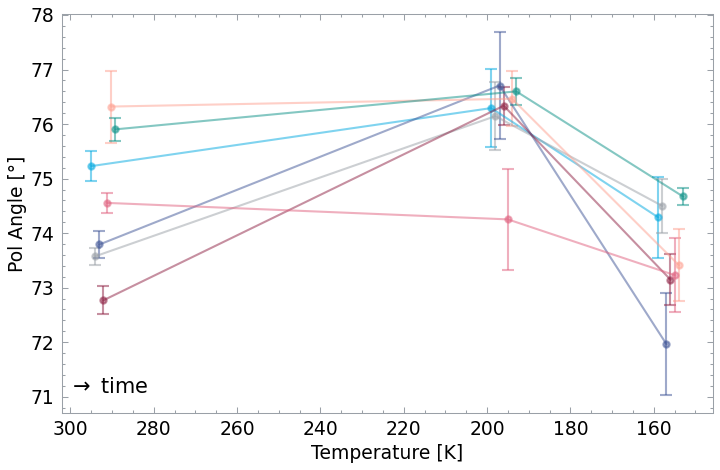

In [10]:
def get_angle(a):
	fit = fit_cos_sqr(a.angle, a.sel(wavelength=slice(543,544)).mean("wavelength").values)
	angle = fit[0][1] * 180/np.pi
	error = np.sqrt(fit[1][1,1]) * 180/np.pi
	return angle, error

items = groupby_list(
	[a for a in anisotropy if "2024-01-03" in a.path],
	lambda a: a.flake
)

for k, v in items.items():
	angles, errors = zip(*[get_angle(a) for a in v])
	plt.errorbar(
    	[iv.temperature -1*k for iv in v], 
     	angles, errors, 
      	fmt="o", 
		label=f"flake {k}", 
		linestyle="-",
		alpha=0.5
    )

# plt.legend(fontsize=FONTSIZE_TINY)
plt.text(0.01, 0.05, r"$\rightarrow$ time",transform=plt.gca().transAxes)
plt.gca().invert_xaxis()
plt.xlabel("Temperature [K]")
plt.ylabel("Pol Angle [°]")
plt.savefig("../figures/2024-01-03 flake pol rotation.png")
plt.savefig("../report/figures/2024-01-03 NiPS3 flake rotation.pdf")
plt.show()